# Vanilla GAN for Moving Box Prediction

In [1]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

## Load data

imgs shape:     (14, 32, 32)
info:           {'images:': 'moving box uniform', 'dim': (14, 32, 32)}


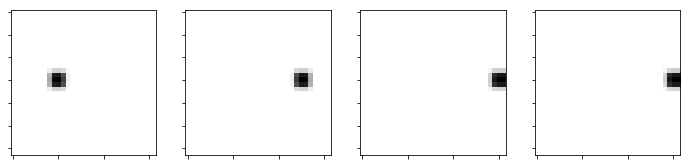

In [3]:
data_path = "data/moving-box/processed/single-uniform-32x32.npz"
data = np.load(data_path)
imgs, info = data['imgs'], data['info']
print("imgs shape:     {}".format(imgs.shape))
print("info:           {}".format(info))
num_train = imgs.shape[0]
sample_and_show_many(imgs, 4)

### Proprocess: [0, 1] -> [-1, 1]

In [4]:
def preprocess(imgs):
    return imgs*2 - 1

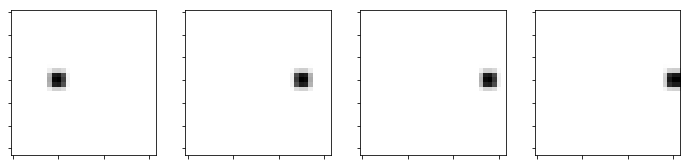

In [5]:
imgs = preprocess(imgs)
sample_and_show_many(imgs, 4)

#### Sample Data from Training Corpus

In [8]:
gap = 3
batch_size = 8
def sample_real():
    """
    return: (before, after), mid
    """
    before_indexes = np.random.choice(range(len(imgs) - gap - 1), batch_size, replace=False)
    before_indexes.sort()
    after_indexes = before_indexes + gap + 1
    mid_indexes = (before_indexes + after_indexes)//2
    return (imgs[before_indexes], imgs[after_indexes]), imgs[mid_indexes]

#### test sample_real

Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


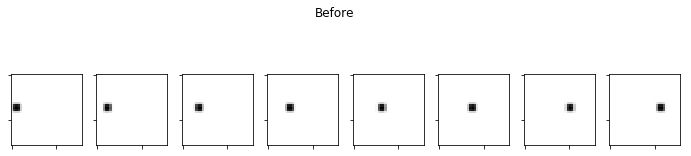

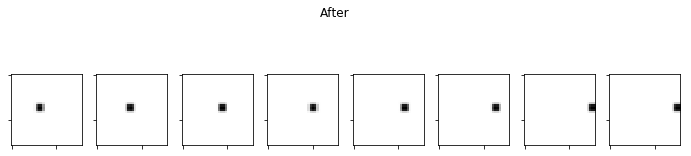

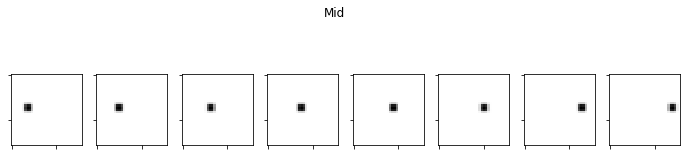

In [9]:
(test_before, test_after), test_mid = sample_real()
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (12, 3)
plot_images(test_before, size, "Before")
plot_images(test_after, size, "After")
plot_images(test_mid, size, "Mid")

#### test stack

In [10]:
stacked = stack_imgs([test_before, test_after])
print("Stacked: {}".format(stacked.shape))

Stacked: (8, 32, 32, 2)


## GAN

In [11]:
def leaky_relu(x, alpha=0.01):
    return tf.maximum(alpha * x, x)

### Params

In [57]:
learning_rate = 2e-4
beta = 0.5
num_epoch = 500
noise_dim = 128

### Loss

In [58]:
def gan_loss(logits_real, logits_fake):
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits = logits_fake)
    
    D_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits = logits_real)\
     +  tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits = logits_fake)
        
    G_loss = tf.reduce_mean(G_loss)
    D_loss = tf.reduce_mean(D_loss)
    return D_loss, G_loss

## Discriminator

In [59]:
def discriminate(x):
    with tf.variable_scope("discriminator"):
        x = tf.reshape(x, [-1,  32, 32, 1])
        x = tf.layers.conv2d(x, filters=32, kernel_size=5)
        x = leaky_relu(x, 0.01)
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding="VALID")
        
        x = tf.layers.conv2d(x, 64, kernel_size=5)
        x = leaky_relu(x, 0.01)
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding="VALID")
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 4*4*64)
        x = leaky_relu(x, 0.01)
        logits = tf.layers.dense(x, 1)
        return logits

## Generator

In [60]:
def generate(x1, x2,  is_training=True):
    """
    Input:
        x1, x2: batch size of images for inference
    Output:
        predicted images of batch size
    """
    with tf.variable_scope("generator"):
        # reshape and concatenate
        x1 = tf.reshape(x1, [-1,  32, 32, 1])
        x2 = tf.reshape(x2, [-1,  32, 32, 1])
        x = tf.concat([x1, x2], axis=3)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        
        x = tf.layers.dense(x, 8*8*128, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.reshape(x, [-1, 8, 8, 128])
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        
        img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4),  strides=(2, 2), activation=tf.nn.tanh, padding='same')
        img = tf.reshape(img, [-1, 32, 32, 1])
        return img

### Solver

In [61]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

### Run a GAN !

In [62]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch = generate(batch_before, batch_after)

with tf.variable_scope("") as scope:
    logits_real = discriminate(batch_mid)
    scope.reuse_variables()
    logits_fake = discriminate(G_batch)

D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_solver, G_solver = get_solvers(learning_rate, beta)

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [ ]:
def train(sess, G_step, D_step, G_loss, D_loss, batch_size, num_eposh, plot_every = 40, show_loss_every=40):
    max_iter = int(num_train*num_epoch/batch_size)
    d_losses, g_losses = [], []
    for i in range(max_iter):
        (real_before, real_after), real_mid = sample_real()
        
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        _, D_loss_curr = sess.run([D_train_step, D_loss], dic)
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        
        if i%show_loss_every ==0:
            print("Iteration {}: D_loss = {} | G_loss = {}".format(i, D_loss_curr, G_loss_curr))
            d_losses.append(D_loss_curr)
            g_losses.append(G_loss_curr)
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict={batch_before: test_before, batch_after: test_after, is_training: False})
            plot_batch_images(gen_batch_test, (16, 2) , "Iteration: {}".format(i))
    
    figsize = (16, 3)
    plt.figure(figsize=figsize)
    plt.plot(d_losses)
    plt.title("Discriminator Losses")
    plt.show()
    
    plt.figure(figsize=figsize)
    plt.plot(g_losses)
    plt.title("Generator Losses")
    plt.show()

Iteration 0: D_loss = 1.3919696807861328 | G_loss = 0.8668622374534607


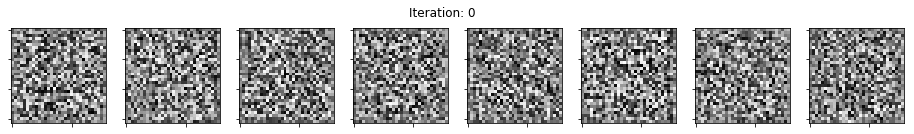

Iteration 40: D_loss = 0.17057594656944275 | G_loss = 6.135510444641113


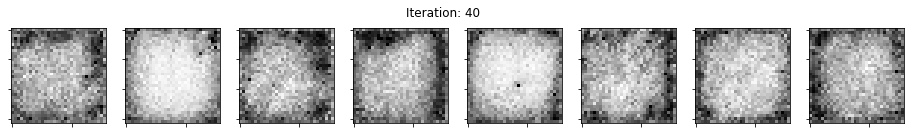

Iteration 80: D_loss = 0.035489290952682495 | G_loss = 8.155279159545898


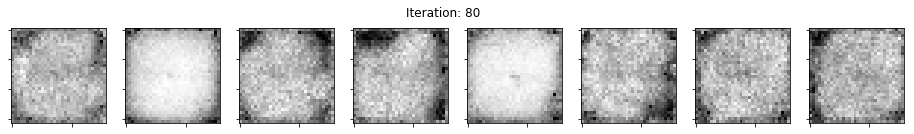

Iteration 120: D_loss = 0.03728969767689705 | G_loss = 8.041812896728516


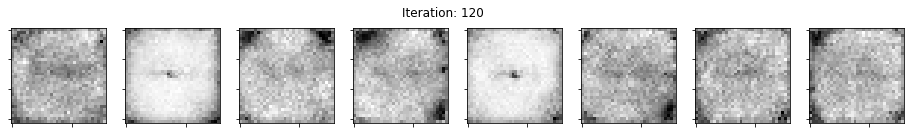

Iteration 160: D_loss = 1.0127663612365723 | G_loss = 5.990837097167969


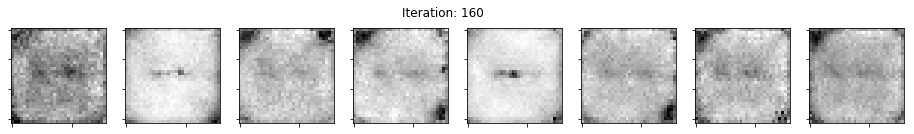

Iteration 200: D_loss = 0.5829247236251831 | G_loss = 4.7914557456970215


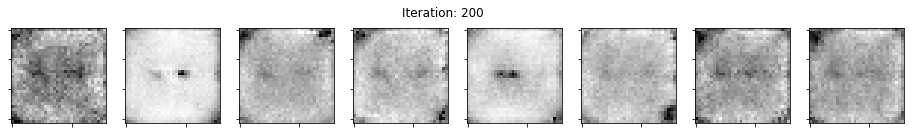

Iteration 240: D_loss = 0.0099988067522645 | G_loss = 8.500300407409668


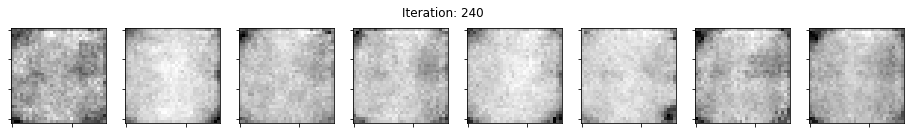

Iteration 280: D_loss = 0.01582847163081169 | G_loss = 8.276896476745605


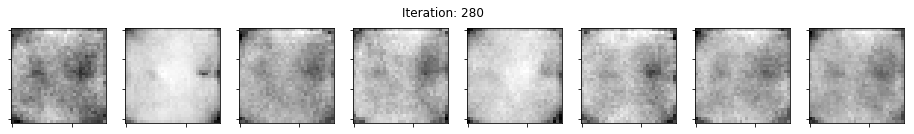

Iteration 320: D_loss = 0.030589722096920013 | G_loss = 8.324538230895996


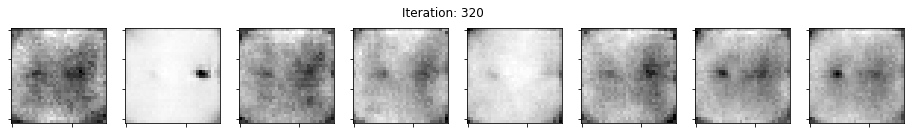

Iteration 360: D_loss = 0.05727073550224304 | G_loss = 4.569509983062744


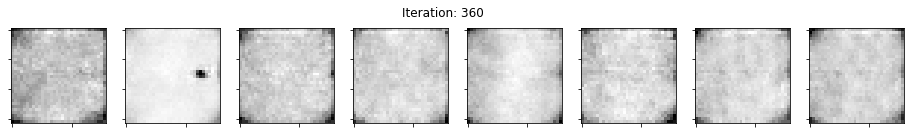

Iteration 400: D_loss = 0.021000895649194717 | G_loss = 5.538398265838623


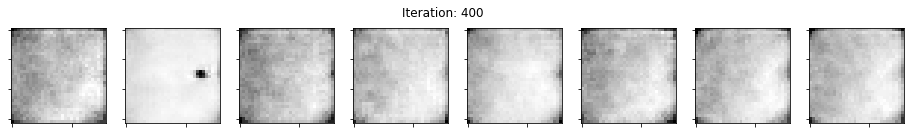

Iteration 440: D_loss = 0.03470362722873688 | G_loss = 4.9279375076293945


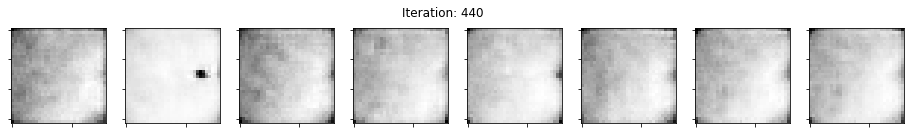

Iteration 480: D_loss = 0.2019936591386795 | G_loss = 3.414374351501465


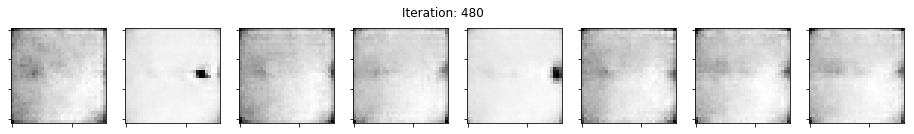

Iteration 520: D_loss = 0.5791984796524048 | G_loss = 1.8498975038528442


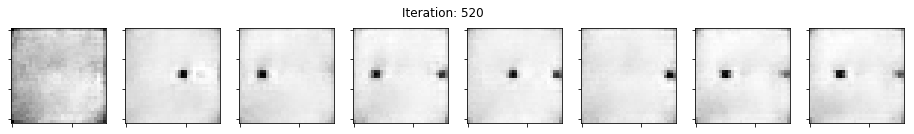

Iteration 560: D_loss = 0.6354891061782837 | G_loss = 0.7776088118553162


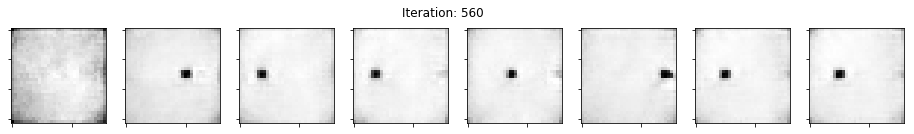

Iteration 600: D_loss = 0.5431230068206787 | G_loss = 1.8707424402236938


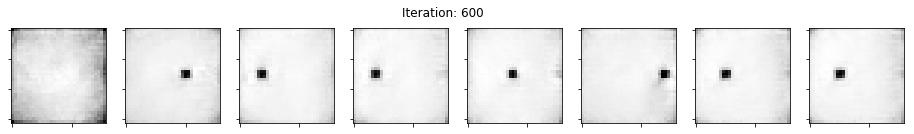

In [ ]:
sess = get_session()
sess.run(tf.global_variables_initializer())
train(sess, G_train_step, D_train_step, G_loss, D_loss, batch_size, num_epoch)

#### test

In [ ]:
def test():
    """
    randomely sample and test generator
    """
    (real_before, real_after), real_mid = sample_real()
    dic = {batch_before: real_before, batch_after: real_after, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    size = (12, 2)
    plot_images(real_before, size, "Before")
    plot_images(real_after, size, "After")
    plot_images(real_mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

In [ ]:
test()